In [1]:
%%bash 
source activate new_scanpy

In [78]:
import scanpy as sc
from os.path import join
import seaborn as sns
import pandas as pd
import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"
import gget
import pybiomart
import numpy as np
from scipy.stats import median_abs_deviation

In [3]:

import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()


%load_ext rpy2.ipython

Wed Jun 21 14:26:59 2023 INFO cffi mode is CFFI_MODE.ANY
Wed Jun 21 14:26:59 2023 INFO R home found: /opt/jupyterhub/lib/R
Wed Jun 21 14:26:59 2023 INFO R library path: 
Wed Jun 21 14:26:59 2023 INFO LD_LIBRARY_PATH: 
Wed Jun 21 14:26:59 2023 INFO Default options to initialize R: rpy2, --quiet, --no-save
Wed 21 Jun 2023 02:27:00 PM CEST INFO R is already initialized. No need to initialize.


In [16]:
pd.read_csv( "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/csvs/X_processed.csv",index_col="genes")
pd.read_csv("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/csvs/doublet_data.csv", index_col = "cell_id")

,doublet_score,doublet_class
cell_id,,
Day0_AAACCTGAGGGTCGAT-1,0.000650,singlet
Day0_AAACCTGAGTCAAGGC-1,0.000506,singlet
Day0_AAACCTGAGTTACGGG-1,0.031744,singlet
Day0_AAACCTGAGTTAGGTA-1,0.000582,singlet
Day0_AAACCTGCACAGACTT-1,0.000538,singlet
...,...,...
Day0_TGCGCAGCACGACGAA-1,0.001374,singlet
Day0_TGCGTGGTCTCAAGTG-1,0.000020,singlet
Day0_TGTCCCATCCTTAATC-1,0.000620,singlet


In [3]:
os.environ['R_HOME'] 

KeyError: 'R_HOME'

In [24]:
server = pybiomart.Server(host='nov2020.archive.ensembl.org')
server.list_marts()

,name,display_name
0,ENSEMBL_MART_ENSEMBL,Ensembl Genes 102
1,ENSEMBL_MART_MOUSE,Mouse strains 102
2,ENSEMBL_MART_SEQUENCE,Sequence
3,ENSEMBL_MART_ONTOLOGY,Ontology
4,ENSEMBL_MART_GENOMIC,Genomic features 102
5,ENSEMBL_MART_SNP,Ensembl Variation 102
6,ENSEMBL_MART_FUNCGEN,Ensembl Regulation 102


In [3]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name"],host = "jul2018.archive.ensembl.org"
    ).set_index("ensembl_gene_id")


new_anot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name"]
    ).set_index("ensembl_gene_id")

In [2]:
base_path="/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/"
project="TabularMuris"

adata =sc.read_h5ad(filename=join(base_path, project, "senis_droplet_lung.h5ad"))

adata.var_names_make_unique()

/omics/groups/OE0436/internal/heyer/conda/envs/scanpy3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/omics/groups/OE0436/internal/heyer/conda/envs/scanpy3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(P)]"))

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 17491 × 19860
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

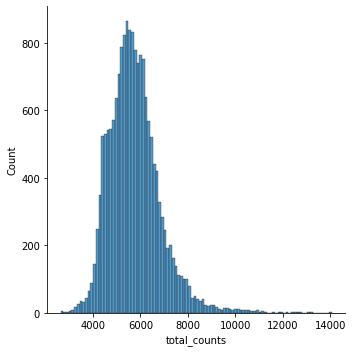

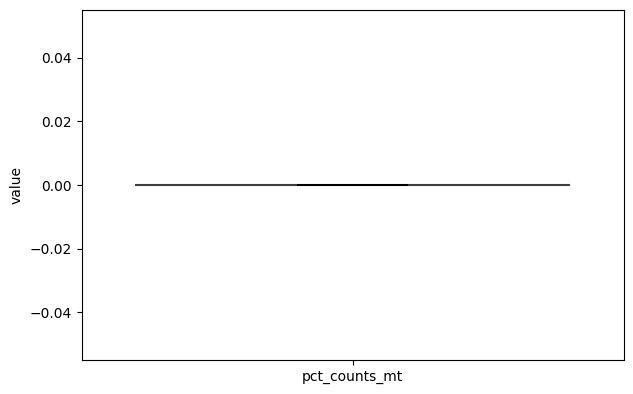

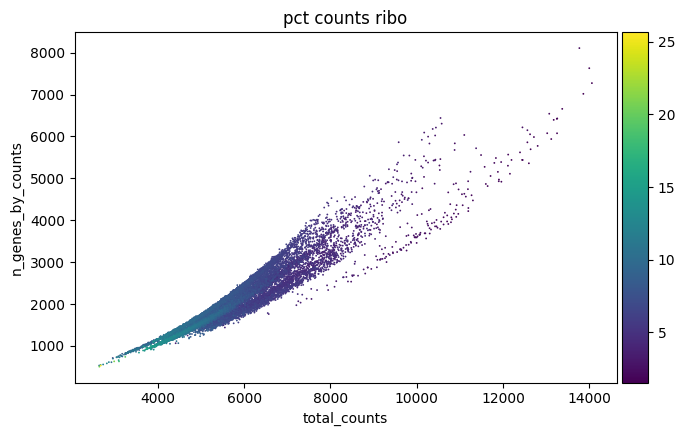

In [5]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

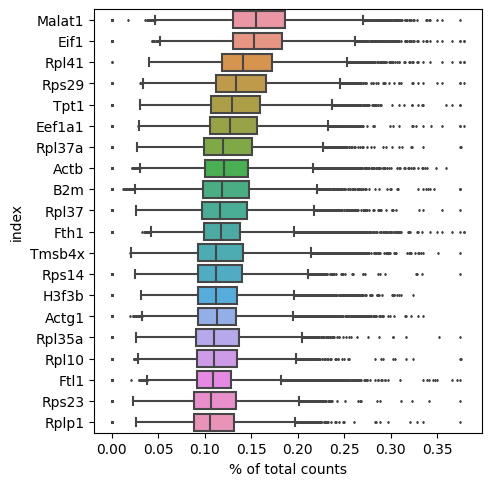

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [1]:
adata

NameError: name 'adata' is not defined

In [75]:
samples = list()
basal = sc.read_10x_mtx("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps", 
                        prefix = "GSM4472505_Basal_", var_names = "gene_ids")
base_path ="/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps" 
adata = sc.read_mtx(join(base_path, 'GSM4472505_Basal_' + "mtx.gz")
                    


adata= adata.T
adata.obs['cell_id']= adata_bc
adata.var['gene_name']= adata_features[0].tolist()
adata.var.index= adata.var['gene_name']


SyntaxError: invalid syntax (2462545903.py, line 9)

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


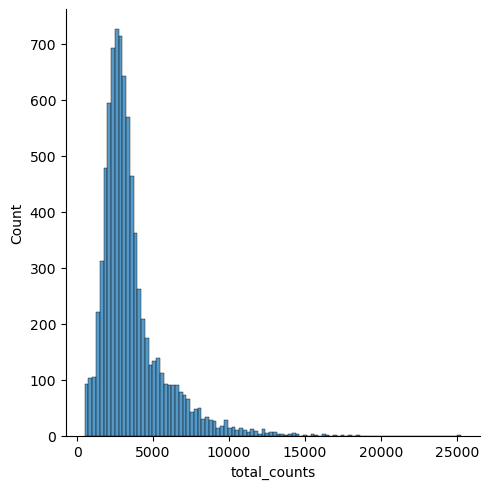

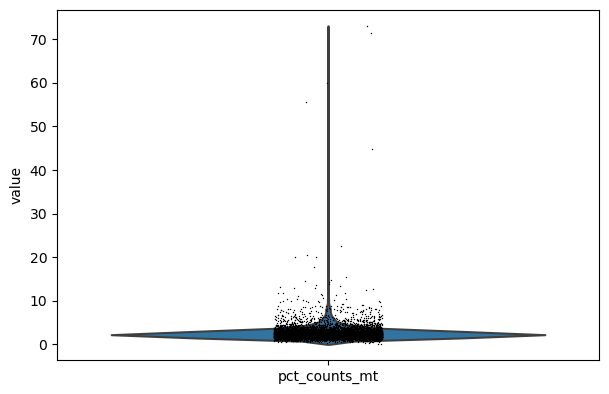

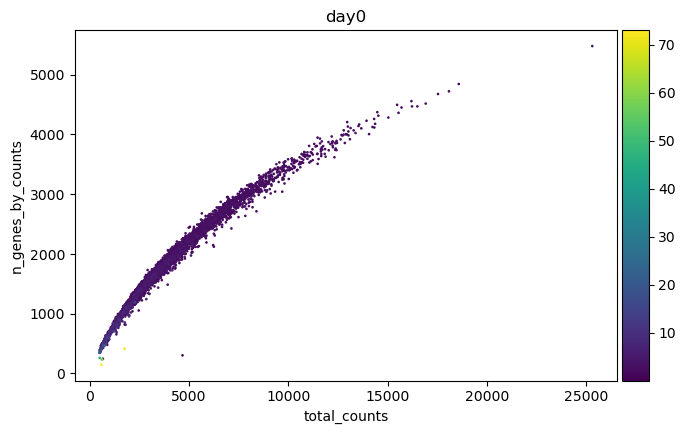

Total number of cells: 8274
Number of cells after filtering of low quality cells: 7408


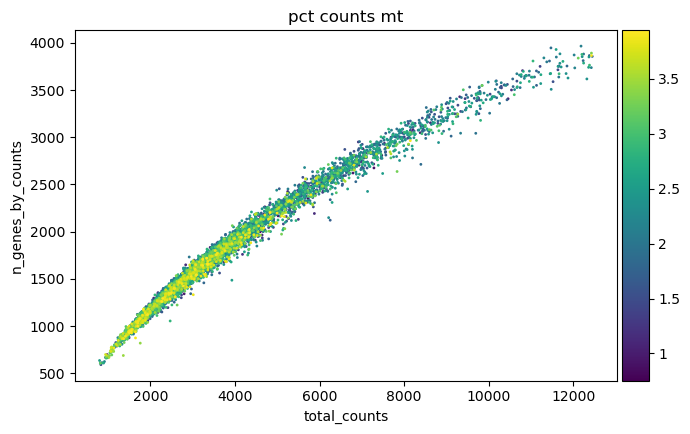

In [36]:
base_path ="/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps" 

sample_name = 'GSM4472505_Basal'
sample_dict = {"day0": 'GSM4472505_Basal',
               "Hour6": "GSM4472506_Hour6",
              "Day1": "GSM4472507_Day1",
              "Day2": "GSM4472508_Day2",
              "Day3": "GSM4472509_Day3",
              "Day7": "GSM4472510_Day7"}
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

def read_and_process_10x(base_path, col_name):
    sample_name = sample_dict[col_name]
    adata = sc.read_mtx(join(base_path, sample_name + "_matrix.mtx.gz"))
    adata_bc=pd.read_csv(join(base_path, sample_name + '_barcodes.tsv.gz'),header=None)
    adata_features=pd.read_csv(join(base_path, sample_name + '_features.tsv.gz',),header=None)


    adata= adata.T
    adata.obs['cell_id']= adata_bc[0].tolist()
    adata.obs["sample"] = col_name
    adata.var['gene_id']= adata_features[0].tolist()
    adata.var['ensembl_93'] = annot.loc[adata.var['gene_id'], "external_gene_name"].tolist()
    adata.var.index= adata.var['ensembl_93']
    adata.var_names_make_unique()
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(P)]"))
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    x= adata.var.total_counts == 0
    x.value_counts()
    
    p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False,)
    p1.set_titles(col_name)
# sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(adata, "pct_counts_mt", title=col_name)
    p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",title=col_name)
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs.outlier.value_counts()
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    adata.obs.mt_outlier.value_counts()
    p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

    return(adata)

adata_one = read_and_process_10x(base_path, "day0")

In [37]:
test=map(lambda x: read_and_process_10x(base_path = base_path, col_name = x), sample_dict.keys())

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


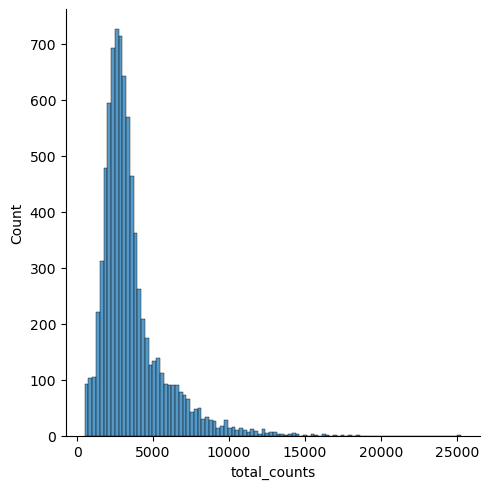

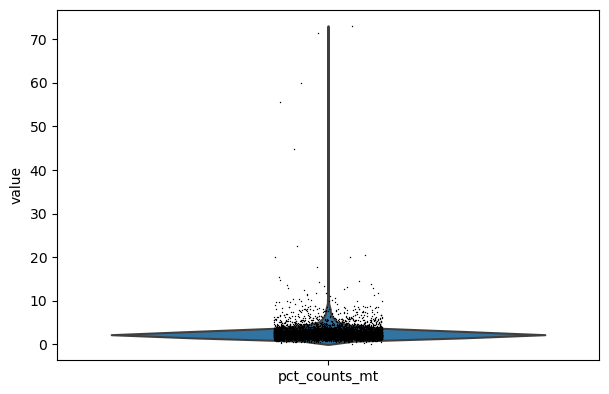

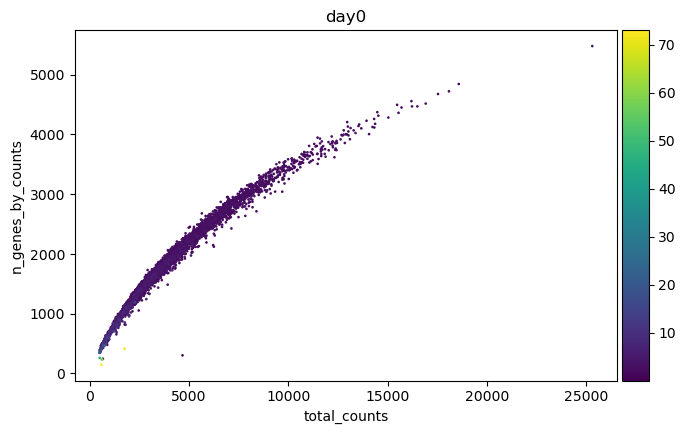

Total number of cells: 8274
Number of cells after filtering of low quality cells: 7408


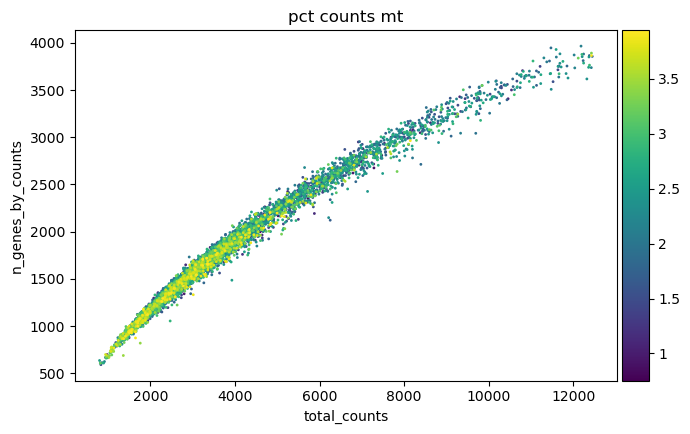

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


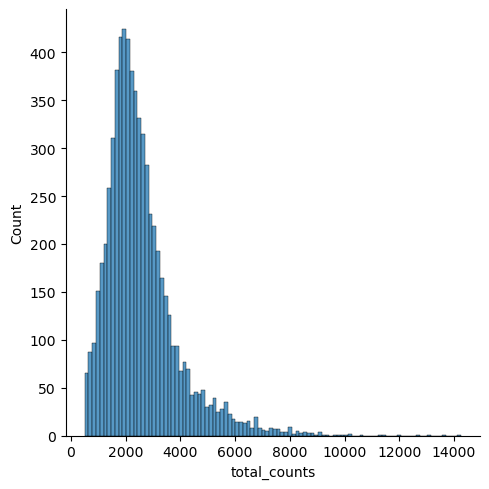

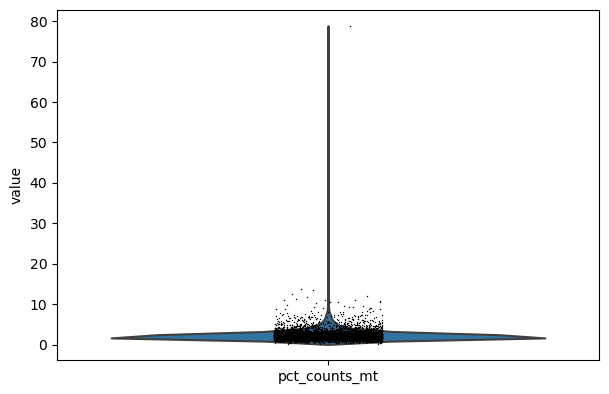

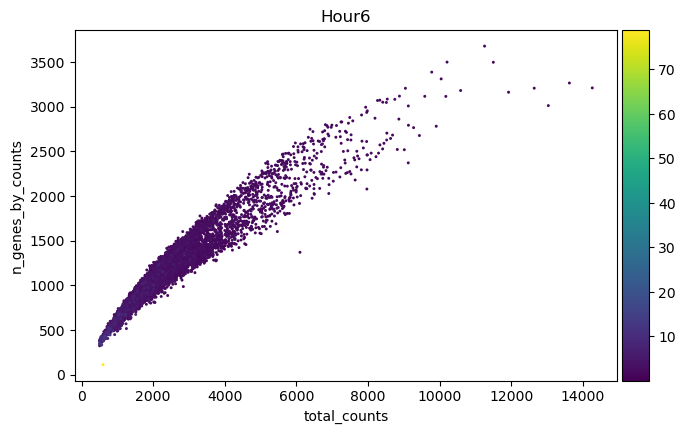

Total number of cells: 6721
Number of cells after filtering of low quality cells: 6047


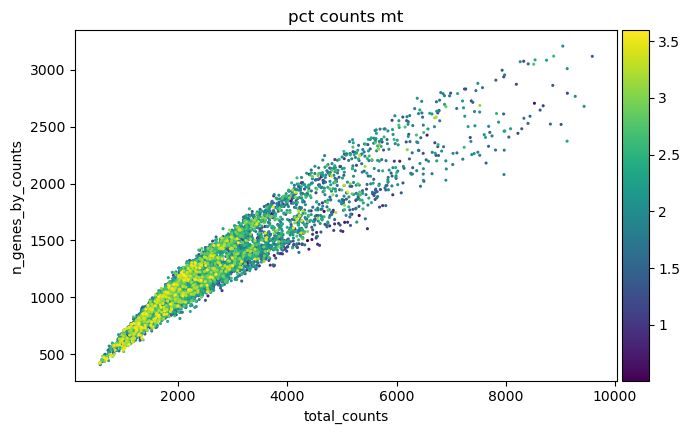

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


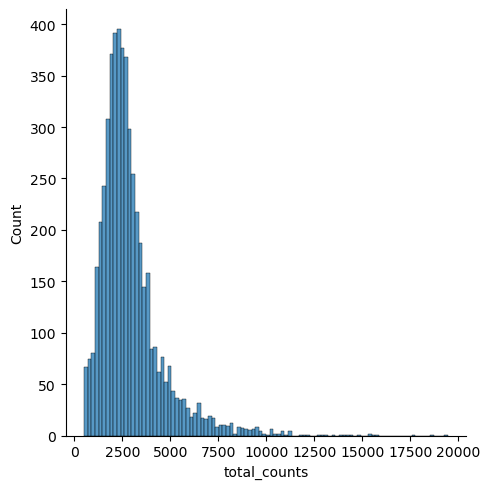

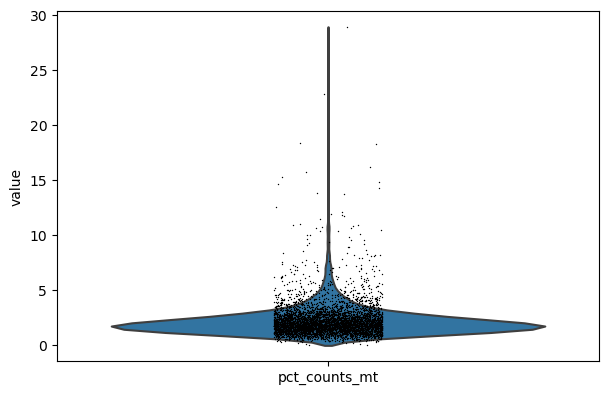

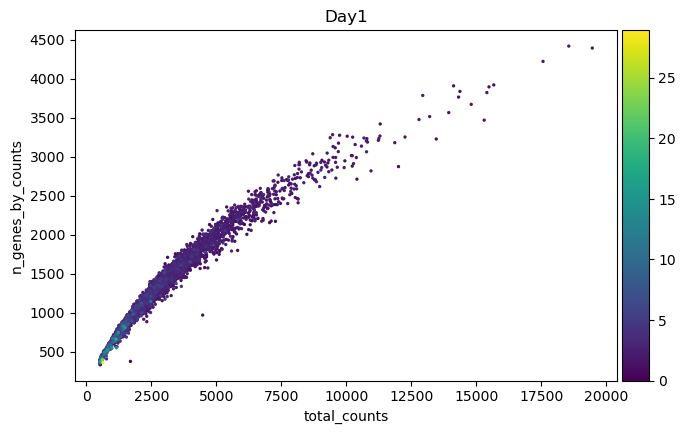

Total number of cells: 5187
Number of cells after filtering of low quality cells: 4648


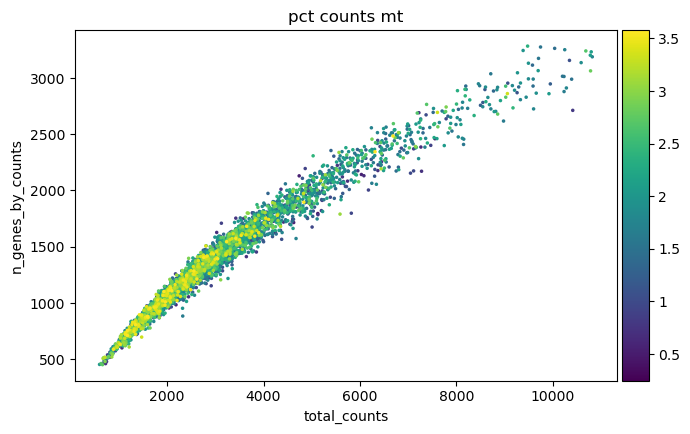

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


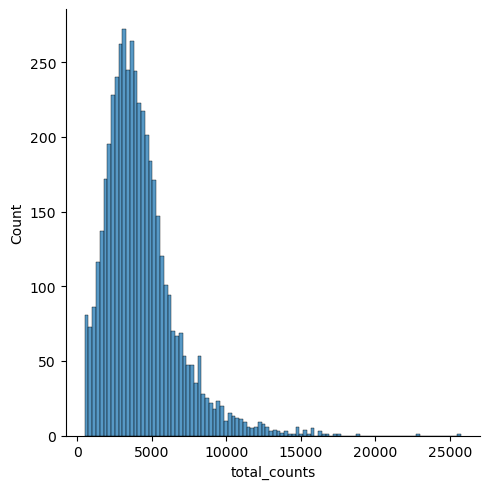

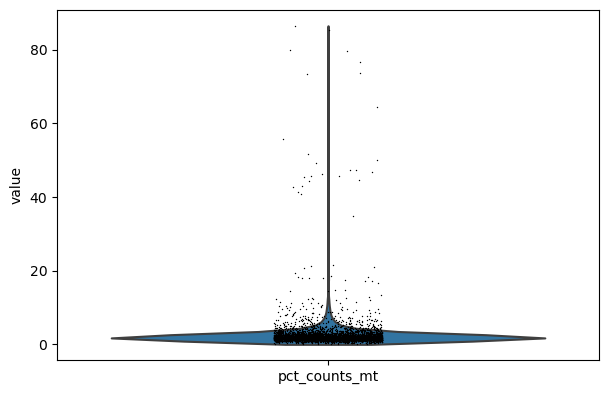

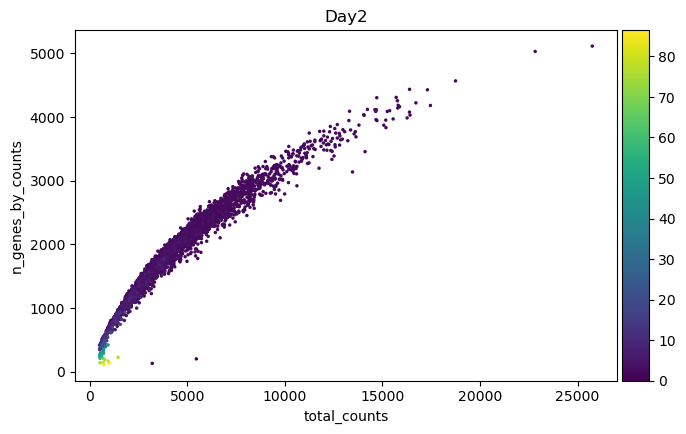

Total number of cells: 4804
Number of cells after filtering of low quality cells: 4127


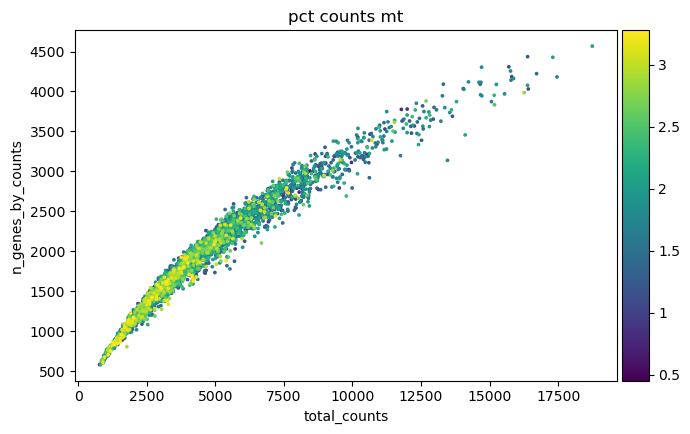

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


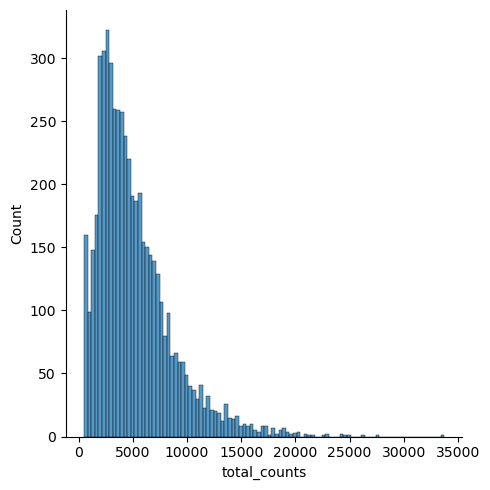

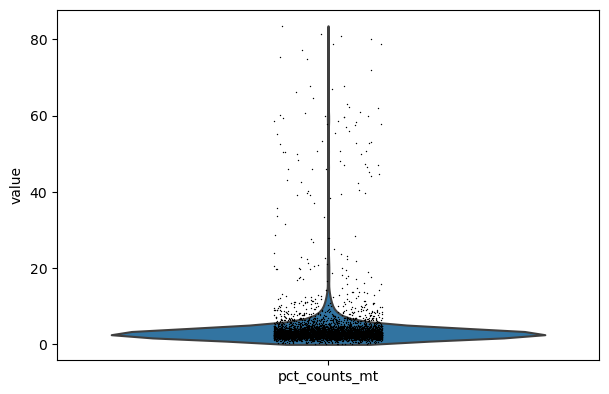

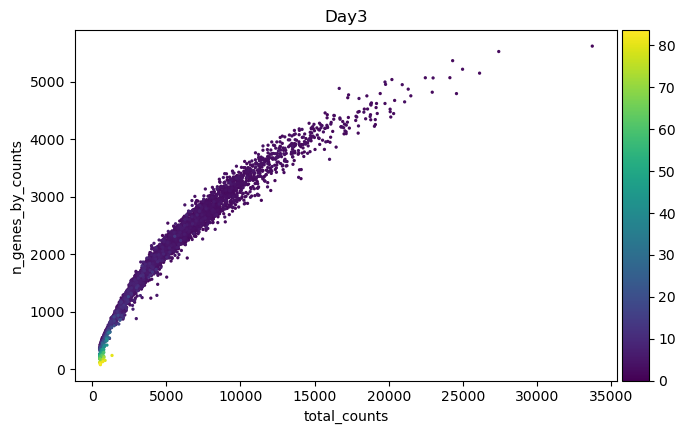

Total number of cells: 5368
Number of cells after filtering of low quality cells: 4684


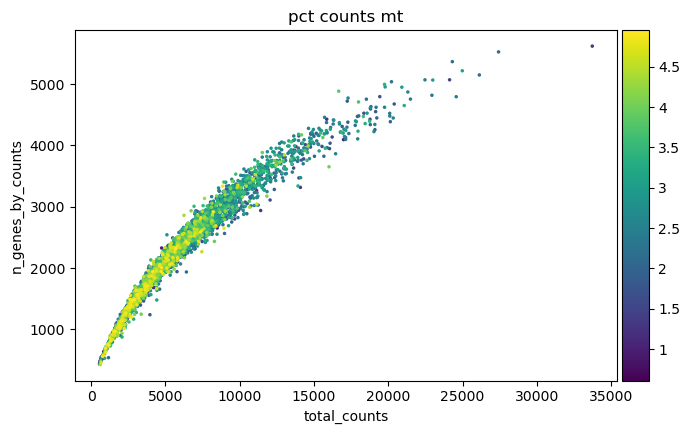

... storing 'sample' as categorical
... storing 'ensembl_93' as categorical


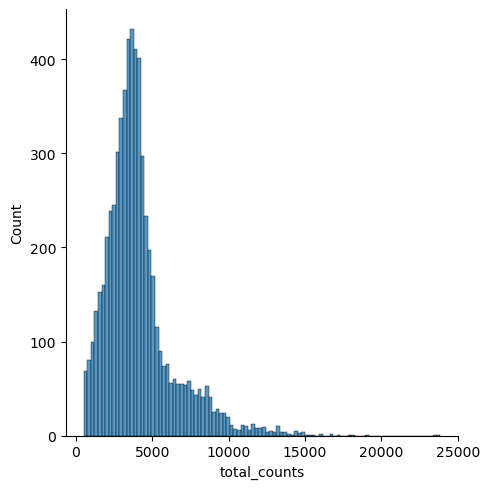

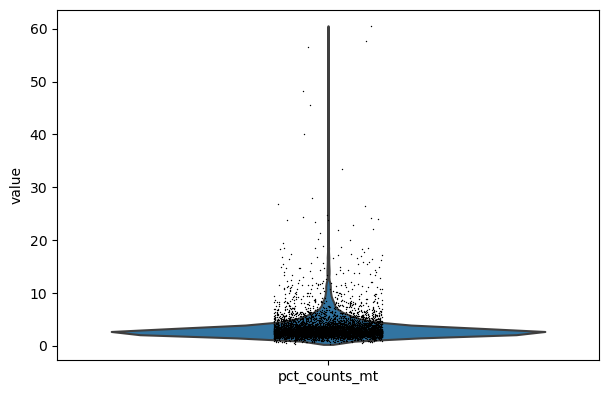

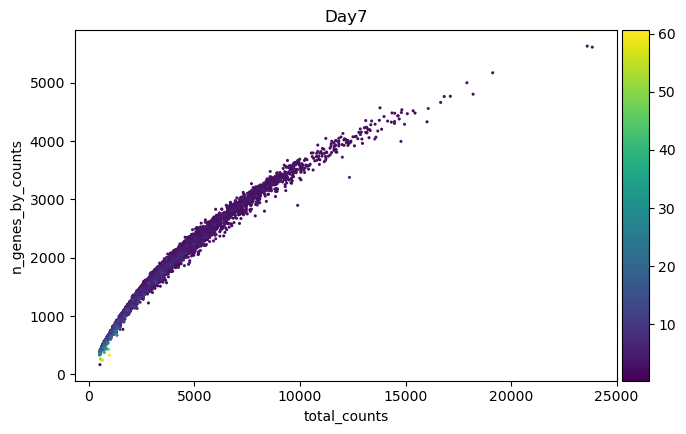

Total number of cells: 6197
Number of cells after filtering of low quality cells: 5217


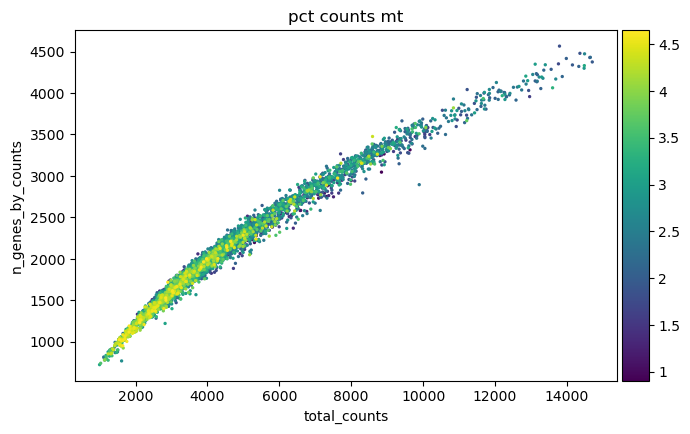

In [38]:
adata_list =list(test)


### annot.loc[adata_one.var_names]

In [39]:
adata_list[0].concatenate(adata)


<bound method AnnData.concatenate of AnnData object with n_obs × n_vars = 7408 × 31053
    obs: 'cell_id', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_id', 'ensembl_93', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'>

,gene_id,ensembl_93,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ensembl_93,,,,,,,,,,,
Xkr4,ENSMUSG00000051951,Xkr4,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
Gm1992,ENSMUSG00000089699,Gm1992,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
Gm37381,ENSMUSG00000102343,Gm37381,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
Rp1,ENSMUSG00000025900,Rp1,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
Sox17,ENSMUSG00000025902,Sox17,False,False,False,4266,1.025985,0.706056,48.440899,8489.0,9.046644
...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,ENSMUSG00000079808,AC168977.1,False,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
AC149090.1,ENSMUSG00000095041,AC149090.1,False,False,False,3174,0.533237,0.427381,61.638869,4412.0,8.392310
CAAA01118383.1,ENSMUSG00000063897,CAAA01118383.1,False,False,False,945,0.125212,0.117971,88.578680,1036.0,6.944087


In [2]:
out = pd.read_csv( "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/csvs/X_processed.csv",index_col="genes")
doublet_data = pd.read_csv("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/csvs/doublet_data.csv", index_col = "cell_id")



In [3]:
adata = sc.read_h5ad("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/adata.h5ad")
adata.obs=adata.obs.set_index("cell_id")


In [4]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]



In [5]:
sc.pp.filter_genes(adata, min_cells=20)

In [23]:
doublet_data.doublet_score

cell_id
Day0_AAACCTGAGGGTCGAT-1    0.000650
Day0_AAACCTGAGTCAAGGC-1    0.000506
Day0_AAACCTGAGTTACGGG-1    0.031744
Day0_AAACCTGAGTTAGGTA-1    0.000582
Day0_AAACCTGCACAGACTT-1    0.000538
                             ...   
Day0_TGCGCAGCACGACGAA-1    0.001374
Day0_TGCGTGGTCTCAAGTG-1    0.000020
Day0_TGTCCCATCCTTAATC-1    0.000620
Day0_TTAGGACCAATGGACG-1    0.001172
Day0_TTTACTGAGGATGTAT-1    0.000617
Name: doublet_score, Length: 7408, dtype: float64

In [67]:
adata.obs["scDblFinder_score"] = doublet_data["doublet_score"]
adata.obs["scDblFinder_class"] = doublet_data["doublet_class"]

In [68]:
adata.obs


,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,scDblFinder_score,scDblFinder_class
cell_id,,,,,,,,,,,,,,,,,,,
Day0_AAACCTGAGGGTCGAT-1,test,1089,6.993933,1765.0,7.476472,16.203966,31.0,3.465736,1.756374,128.0,4.859812,7.252125,1.0,0.693147,0.056657,False,False,0.000650,singlet
Day0_AAACCTGAGTCAAGGC-1,test,1782,7.486053,3412.0,8.135347,12.778429,98.0,4.595120,2.872216,343.0,5.840641,10.052754,1.0,0.693147,0.029308,False,False,0.000506,singlet
Day0_AAACCTGAGTTACGGG-1,test,1307,7.176255,2530.0,7.836370,17.430830,56.0,4.043051,2.213439,268.0,5.594711,10.592885,0.0,0.000000,0.000000,False,False,0.031744,singlet
Day0_AAACCTGAGTTAGGTA-1,test,1792,7.491645,3496.0,8.159660,13.787185,85.0,4.454347,2.431350,303.0,5.717028,8.667048,0.0,0.000000,0.000000,False,False,0.000582,singlet
Day0_AAACCTGCACAGACTT-1,test,1699,7.438384,3409.0,8.134467,15.840422,129.0,4.867535,3.784101,371.0,5.918894,10.882957,1.0,0.693147,0.029334,False,False,0.000538,singlet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Day0_TGCGCAGCACGACGAA-1,test,2286,7.734996,5009.0,8.519191,12.337792,81.0,4.406719,1.617089,734.0,6.599871,14.653624,0.0,0.000000,0.000000,False,False,0.001374,singlet
Day0_TGCGTGGTCTCAAGTG-1,test,1305,7.174724,2440.0,7.800163,19.795082,34.0,3.555348,1.393443,271.0,5.605802,11.106558,0.0,0.000000,0.000000,False,False,0.000020,singlet
Day0_TGTCCCATCCTTAATC-1,test,1802,7.497207,3855.0,8.257385,20.285344,56.0,4.043051,1.452659,465.0,6.144186,12.062257,0.0,0.000000,0.000000,False,False,0.000620,singlet


In [54]:
adata.obs=adata.obs.set_index("cell_id")

In [55]:
adata.obs["scDblFinder_score"] = doublet_data["doublet_score"]

In [69]:
adata.var

,gene_id,ensembl_93,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
ensembl_93,,,,,,,,,,,,
Sox17,ENSMUSG00000025902,Sox17,False,False,False,4266,1.025985,0.706056,48.440899,8489.0,9.046644,3482
Mrpl15,ENSMUSG00000033845,Mrpl15,False,False,False,1701,0.233623,0.209956,79.441624,1933.0,7.567346,1380
Lypla1,ENSMUSG00000025903,Lypla1,False,False,False,2021,0.287890,0.253005,75.574088,2382.0,7.776115,1653
Tcea1,ENSMUSG00000033813,Tcea1,False,False,False,2527,0.385787,0.326268,69.458545,3192.0,8.068716,2066
Atp6v1h,ENSMUSG00000033793,Atp6v1h,False,False,False,1407,0.190114,0.174049,82.994924,1573.0,7.361375,1121
...,...,...,...,...,...,...,...,...,...,...,...,...
Vamp7,ENSMUSG00000051412,Vamp7,False,False,False,1517,0.210660,0.191166,81.665458,1743.0,7.463937,1246
Tmlhe,ENSMUSG00000079834,Tmlhe,False,False,False,27,0.003384,0.003378,99.673677,28.0,3.367296,21
AC149090.1,ENSMUSG00000095041,AC149090.1,False,False,False,3174,0.533237,0.427381,61.638869,4412.0,8.392310,2616


In [70]:
adata.layers

Layers with keys: counts, soupX_counts

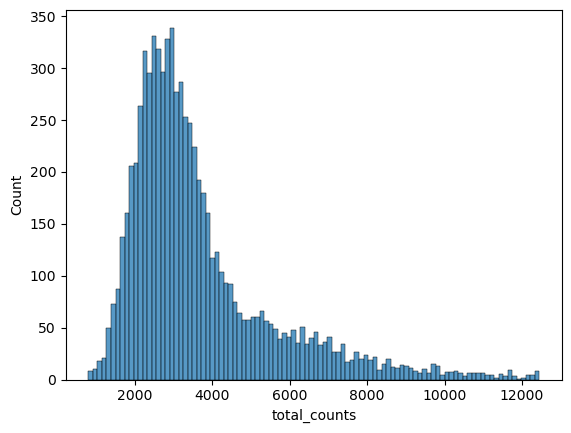

In [71]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [72]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

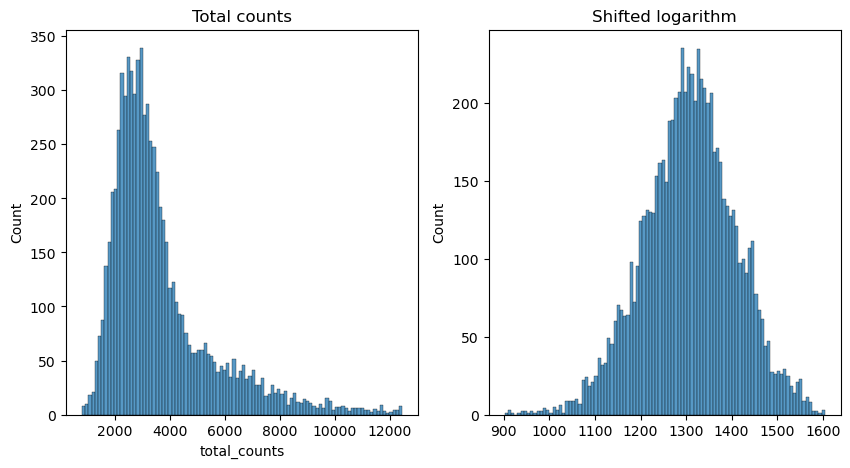

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [6]:
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, issparse

In [79]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [7]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

data_mat = adata_pp.X.T

/omics/groups/OE0436/internal/heyer/conda/envs/new_scanpy/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/omics/groups/OE0436/internal/heyer/conda/envs/new_scanpy/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/omics/groups/OE0436/inter

In [10]:
 adata_pp.obs["groups"].to_csv()

'cell_id,groups\nDay0_AAACCTGAGGGTCGAT-1,7\nDay0_AAACCTGAGTCAAGGC-1,4\nDay0_AAACCTGAGTTACGGG-1,0\nDay0_AAACCTGAGTTAGGTA-1,0\nDay0_AAACCTGCACAGACTT-1,4\nDay0_AAACCTGCACAGATTC-1,3\nDay0_AAACCTGCAGCCTGTG-1,2\nDay0_AAACCTGCAGCTGTGC-1,9\nDay0_AAACCTGGTAGTAGTA-1,2\nDay0_AAACCTGGTATATCCG-1,1\nDay0_AAACCTGGTCCATCCT-1,2\nDay0_AAACCTGGTCGCGTGT-1,4\nDay0_AAACCTGTCAGCGATT-1,5\nDay0_AAACCTGTCGTTTATC-1,3\nDay0_AAACCTGTCTGAGGGA-1,7\nDay0_AAACCTGTCTTAACCT-1,0\nDay0_AAACGGGAGCAATATG-1,7\nDay0_AAACGGGAGGCAATTA-1,0\nDay0_AAACGGGAGTGCCAGA-1,8\nDay0_AAACGGGCACGACGAA-1,4\nDay0_AAACGGGCAGCATGAG-1,4\nDay0_AAACGGGCAGCTCCGA-1,8\nDay0_AAACGGGGTAATTGGA-1,1\nDay0_AAACGGGGTCTCGTTC-1,10\nDay0_AAACGGGGTTACCGAT-1,9\nDay0_AAACGGGGTTGATTCG-1,5\nDay0_AAACGGGGTTTGTGTG-1,10\nDay0_AAACGGGTCCATGAAC-1,0\nDay0_AAACGGGTCTGGAGCC-1,1\nDay0_AAACGGGTCTTTAGGG-1,5\nDay0_AAAGATGAGATATGGT-1,1\nDay0_AAAGATGAGCACCGTC-1,6\nDay0_AAAGATGAGCGTGAAC-1,5\nDay0_AAAGATGAGCTGCAAG-1,7\nDay0_AAAGATGAGGGTATCG-1,3\nDay0_AAAGATGAGTTGAGAT-1,1\nDay0_AAAG

In [24]:
deviance_data = pd.read_csv("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/anndata/csvs/deviance_table.csv")

In [26]:
deviance_data = deviance_data.set_index("genes")


In [64]:
idx = deviance_data["binomial_deviance"].argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

In [71]:
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = deviance_data["binomial_deviance"]

In [72]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_deviant,binomial_deviance
gene_name,,,,,,,,,,,,
Sox17,False,False,False,4266,1.025985,0.706056,48.440899,8489.0,9.046644,3463,True,12865.535830
Mrpl15,False,False,False,1701,0.233623,0.209956,79.441624,1933.0,7.567346,1396,True,5085.865281
Lypla1,False,False,False,2021,0.287890,0.253005,75.574088,2382.0,7.776115,1649,True,5751.715750
Tcea1,False,False,False,2527,0.385787,0.326268,69.458545,3192.0,8.068716,2053,True,6553.858112
Atp6v1h,False,False,False,1407,0.190114,0.174049,82.994924,1573.0,7.361375,1126,True,4616.595911
...,...,...,...,...,...,...,...,...,...,...,...,...
Tmlhe,False,False,False,27,0.003384,0.003378,99.673677,28.0,3.367296,22,False,272.458610
Csprs,False,False,False,23,0.003022,0.003017,99.722021,25.0,3.258096,21,False,258.277856
AC149090.1,False,False,False,3174,0.533237,0.427381,61.638869,4412.0,8.392310,2579,True,7820.926314


In [84]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.X = adata.layers["log1p_norm"]
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

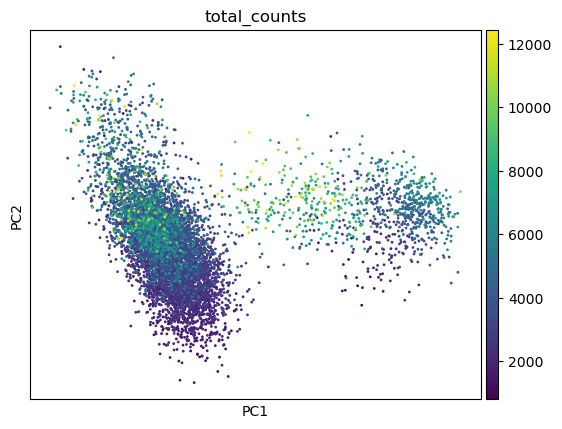

In [85]:
sc.pl.pca_scatter(adata, color="total_counts")

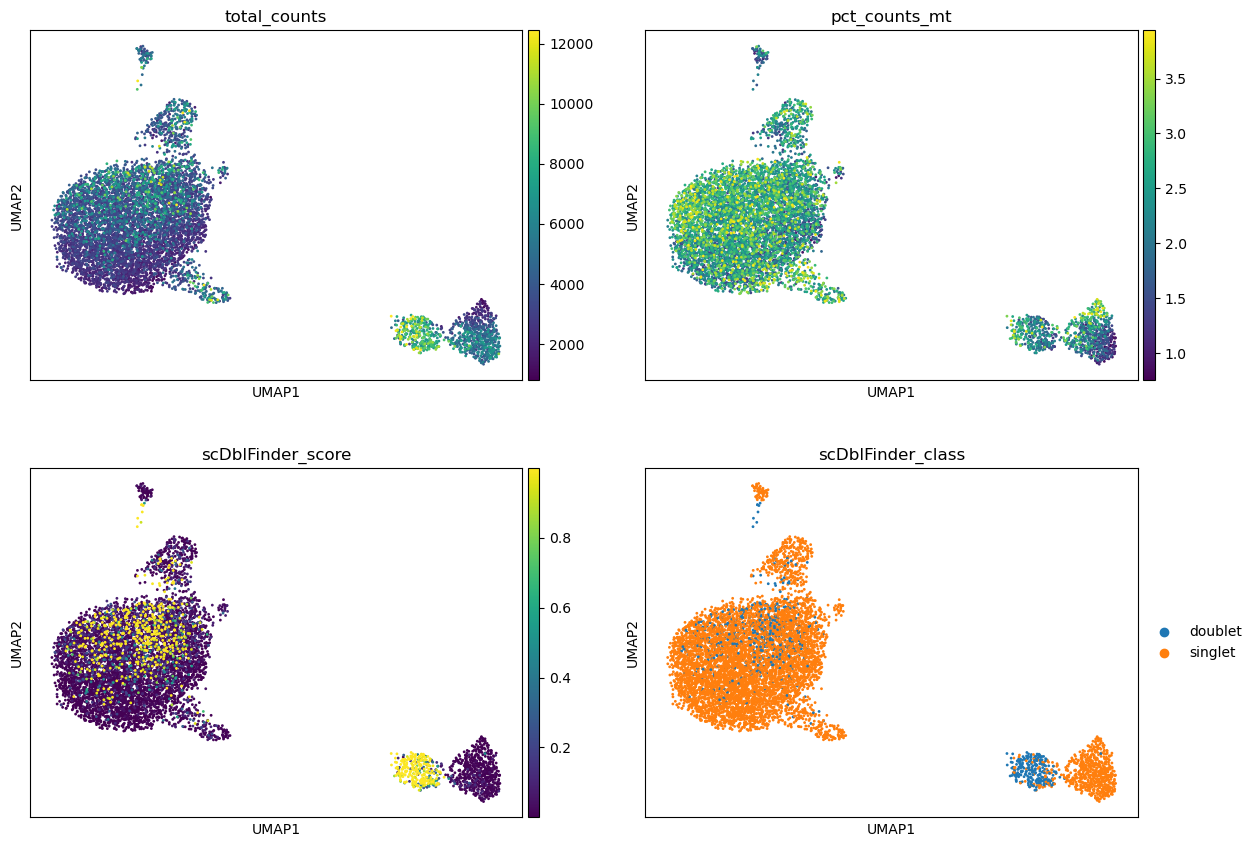

In [86]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
    ncols = 2
)

In [ ]:
adata = sc.read_h5ad("/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/lung_lps/basal/anndata/adata_norm_processed.h5ad")

In [87]:
sc.tl.leiden(adata)

In [88]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)


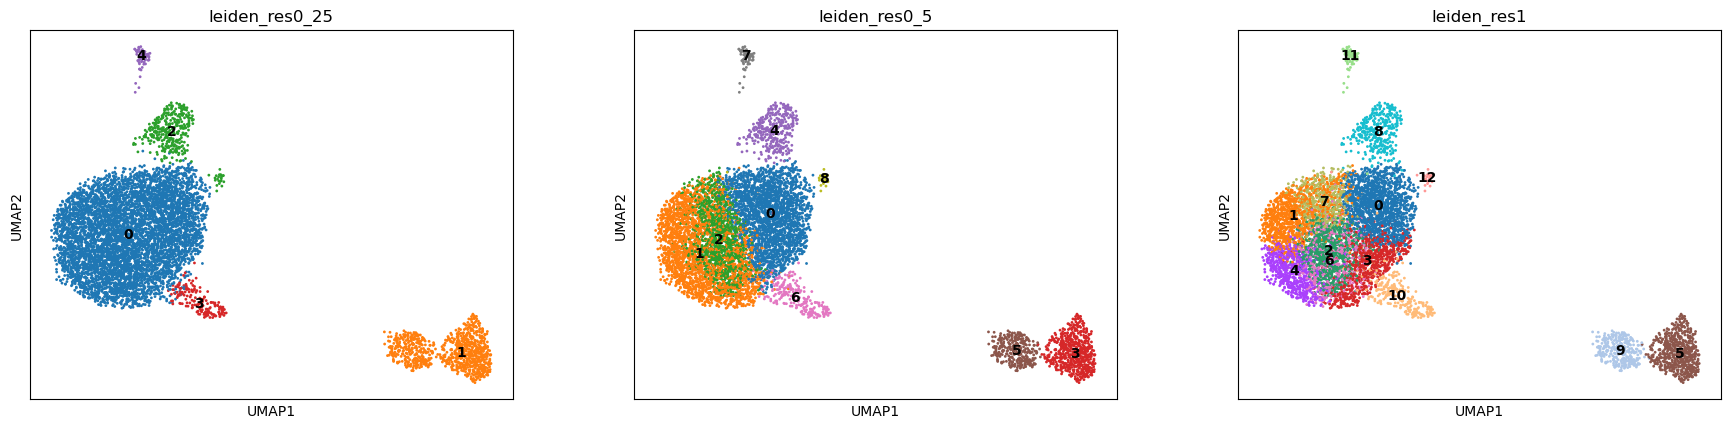

In [89]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)
